<a href="https://colab.research.google.com/github/Gaurav-phatkare/BERT_Model-NLP/blob/main/Twitter_Sentiment_Analysis_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kazanova/sentiment140

 98% 79.0M/80.9M [00:04<00:00, 24.5MB/s]
100% 80.9M/80.9M [00:04<00:00, 18.3MB/s]


In [7]:
!unzip /content/sentiment140.zip

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [8]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)

In [9]:
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']

In [10]:
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

In [11]:
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
# df = df.rename(columns={df.columns[0]: 'target', df.columns[1]: 'id', df.columns[2]: 'date', df.columns[3]: 'query', df.columns[4]: 'username', df.columns[5]: 'content'})

In [13]:
df.shape

(1600000, 2)

In [14]:
# df = df.sample(250000)

In [15]:
df['labels'] = df['Sentiment'].replace([0, 4],['Negative','Positive'])

In [16]:
df.Sentiment.value_counts()

0    800000
4    800000
Name: Sentiment, dtype: int64

In [17]:
df['Sentiment'] = df.Sentiment.replace(4,1)

In [18]:
df.Sentiment.value_counts()

0    800000
1    800000
Name: Sentiment, dtype: int64

#Data Cleaning

In [19]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    # text = mentions.sub(' entity', text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text.strip().lower()

In [20]:
df['Tweet'] = df.Tweet.apply(process_text)

In [21]:
df['Tweet'].head()

0    - awww, that's a bummer.  you shoulda got davi...
1    is upset that he can't update his facebook by ...
2    i dived many times for the ball. managed to sa...
3       my whole body feels itchy and like its on fire
4    no, it's not behaving at all. i'm mad. why am ...
Name: Tweet, dtype: object

In [22]:
df['Tweet'][-5:].values

array(['just woke up. having no school is the best feeling ever',
       'thewdb.com - very cool to hear old walt interviews!  â\x99«',
       'are you ready for your mojo makeover? ask me for details',
       'happy 38th birthday to my boo of alll time!!! tupac amaru shakur',
       'happy hashtag'], dtype=object)

In [23]:
df.drop_duplicates(subset='Tweet',inplace=True)

In [24]:
df.shape

(1541247, 3)

In [25]:
text_len = []
for text in df.Tweet:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [26]:
df['text_len'] = text_len

In [27]:
df.head()

,Sentiment,Tweet,labels,text_len
0,0,"- awww, that's a bummer. you shoulda got davi...",Negative,17
1,0,is upset that he can't update his facebook by ...,Negative,21
2,0,i dived many times for the ball. managed to sa...,Negative,17
3,0,my whole body feels itchy and like its on fire,Negative,10
4,0,"no, it's not behaving at all. i'm mad. why am ...",Negative,20


In [28]:
df = df[df['text_len'] > 3]

In [29]:
df.shape

(1464869, 4)

In [30]:
import tensorflow as tf
!pip install transformers

from transformers import BertTokenizerFast
from transformers import TFBertModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00


In [31]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [32]:
token_lens = []

for txt in df['Tweet'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_len=np.max(token_lens)

In [33]:
df['token_lens'] = token_lens

In [34]:
df = df.sort_values(by='token_lens', ascending=False)

In [35]:
df[:9000]

,Sentiment,Tweet,labels,text_len,token_lens
1582941,1,5 days till new top gear î?î?î?î?î?î?î?...,Positive,7,230
709142,0,à¶¶à¶½à·?à¶à·à¶± à·à¶»à· à¶ºà¶±à·à¶±à· à...,Negative,20,212
1188208,1,à¤à¤¾à¤¨ à¤à¤¤à¤¾ à¥¨ à¤¦à¤¿à¤µà¤¸ à¤¸à¥?à¤...,Positive,25,175
443960,0,firefly ñ?ñð¾ ðºð°ðºð°ñ?-ñð¾ ñ?ð¾ð²ðµññðµð...,Negative,19,173
1324105,1,ð?ðµ ð¼ð¾ð³ñ ñ?ðºð°ð·ð°ññ ð¾ ñð¾ð¿-ð¼ðµð½ð...,Positive,21,172
...,...,...,...,...,...
1153285,1,iï¿½m off to bed! second day tweeting.... awe...,Positive,20,47
506656,0,) :-d (lol) :-p (woot) ;-) :-o x-( :'-( :-&a...,Negative,14,47
809888,1,nï¿½o te consigo mandar direct messages!! &qu...,Positive,18,47
992588,1,oh oh oh.. class will start on wednesday t_t.....,Positive,26,47


In [36]:
df = df[10000:]

In [37]:
df = df.sample(frac=1).reset_index(drop=True)

In [38]:
df = df.sample(500000)

In [39]:
df.head()

,Sentiment,Tweet,labels,text_len,token_lens
23097,0,"it sounds so rainy out, but it's not.",Negative,8,14
922134,0,my best friend is going back to germany today ...,Negative,23,27
1420037,0,y the hell is my computer not charging????????...,Negative,13,30
677227,1,"well, pre-fandom wank: for you",Positive,5,13
761761,0,they are nasty things. i try to recycle my one...,Negative,27,40


In [40]:
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

In [41]:
training_data.shape, testing_data.shape

((400000, 5), (100000, 5))

In [42]:
# import tensorflow as tf
# !pip install transformers

In [43]:
# from transformers import BertTokenizerFast
# from transformers import TFBertModel

In [44]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [45]:
# token_lens = []

# for txt in training_data['Tweet'].values:
#     tokens = tokenizer.encode(txt, max_length=512, truncation=True)
#     token_lens.append(len(tokens))

# max_len=np.max(token_lens)

In [46]:
max_len = np.max(df['token_lens'])
max_len

46

In [47]:
# training_data['token_lens'] = token_lens

In [48]:
# training_df = training_data.sort_values(by='token_lens', ascending=False)

In [49]:
# training_df[:1000]

In [50]:
# training_df = training_df.iloc[1000:]

In [51]:
training_data.shape, testing_data.shape

((400000, 5), (100000, 5))

In [52]:
# training_df = training_df.sample(frac=1).reset_index(drop=True)

<ipython-input-53-d84155e85b77>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(training_data['token_lens'])


<Axes: xlabel='token_lens', ylabel='Density'>

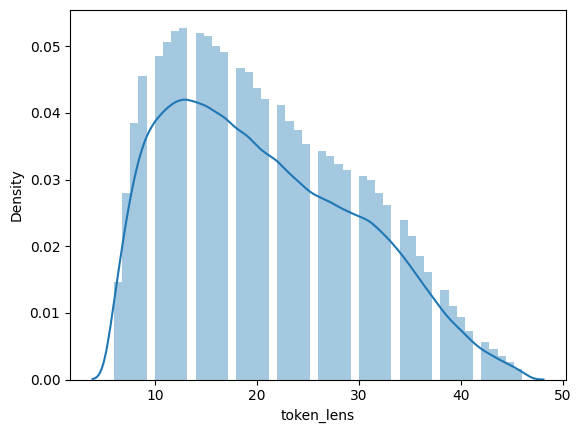

In [53]:
sns.distplot(training_data['token_lens'])

In [54]:
# token_lens_test = []

# for txt in testing_data['Tweet'].values:
#     tokens = tokenizer.encode(txt, max_length=512, truncation=True)
#     token_lens_test.append(len(tokens))

# max_len=np.max(token_lens_test)

In [55]:
max_len

46

In [56]:
# testing_data['token_lens'] = token_lens_test

In [57]:
# testing_df = testing_data.sort_values(by='token_lens', ascending=False)
# testing_df.head(1000)

In [58]:
# testing_df = testing_df.iloc[1000:]
# testing_df.head(10)

In [59]:
# testing_df = testing_df.sample(frac=1).reset_index(drop=True)

In [60]:
# testing_df.head(10)

In [61]:
testing_data.Sentiment.value_counts()

0    50907
1    49093
Name: Sentiment, dtype: int64

In [62]:
training_data.Sentiment.value_counts()

0    203098
1    196902
Name: Sentiment, dtype: int64

In [63]:
X = training_data['Tweet'].values
y = training_data['Sentiment'].values

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [65]:
X_test = testing_data['Tweet'].values
y_test = testing_data['Sentiment'].values

In [66]:
X_train.shape[0], X_val.shape, X_test.shape

(320000, (80000,), (100000,))

# One Hot Encoding

In [67]:
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

In [68]:
from sklearn import preprocessing

OneHot = preprocessing.OneHotEncoder()
y_train = OneHot.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = OneHot.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = OneHot.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# Baseline Model With Naive Bayes and TFIDF

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


# Create tokenization and modelling pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',MultinomialNB())
])

# fit the pipeline to the training data

model_0.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [70]:
# baseline_score = model_0.score(X_val, y_val)

In [71]:
# baseline_score

In [72]:
test_pred = model_0.predict(X_test)

In [73]:
y_test_le

array([0, 0, 1, ..., 1, 1, 1])

In [74]:
# make helper function for accuracy precision recall and f1 score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le, test_pred, target_names = ['Negative', 'Positive']))




	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.75      0.80      0.77     50907
    Positive       0.78      0.73      0.75     49093

    accuracy                           0.76    100000
   macro avg       0.76      0.76      0.76    100000
weighted avg       0.76      0.76      0.76    100000



#BERT Sentiment Analysis

In [75]:
Max_Len = 60

In [76]:
def tokenize(data, max_len = Max_Len):
  input_ids = []
  attention_masks = []

  for i in range(len(data)):
    encoded = tokenizer.encode_plus(
    data[i],
    add_special_tokens = True,
    max_length = max_len,
    padding = 'max_length',
    return_attention_mask = True
    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids), np.array(attention_masks)

In [77]:
train_input_ids, train_attention_masks = tokenize(X_train, Max_Len)
val_input_ids, val_attention_masks = tokenize(X_val, Max_Len)
test_input_ids, test_attention_masks = tokenize(X_test, Max_Len)


In [78]:
len(train_input_ids)

320000

In [79]:
# # Reshape the input tensors to 2D
# train_input_ids = np.expand_dims(train_input_ids, axis=-1)
# train_attention_masks = np.expand_dims(train_attention_masks, axis=-1)
# val_input_ids = np.expand_dims(val_input_ids, axis=-1)
# val_attention_masks = np.expand_dims(val_attention_masks, axis=-1)
# test_input_ids = np.expand_dims(test_input_ids, axis=-1)
# test_attention_masks = np.expand_dims(test_attention_masks, axis=-1)

In [80]:
# train_input_ids.shape

In [81]:
# input_data = [train_input_ids,  train_attention_masks]

In [82]:
# type(y_train)

In [83]:
train_tf_data = tf.data.Dataset.from_tensor_slices((train_input_ids,  train_attention_masks))
train_tf_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_tf_dataset = tf.data.Dataset.zip((train_tf_data, train_tf_labels))
train_tf_dataset = train_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
val_tf_data = tf.data.Dataset.from_tensor_slices((val_input_ids,  val_attention_masks))
val_tf_labels = tf.data.Dataset.from_tensor_slices(y_val)
val_tf_dataset = tf.data.Dataset.zip((val_tf_data, val_tf_labels))
val_tf_dataset = val_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
test_tf_data = tf.data.Dataset.from_tensor_slices((test_input_ids,  test_attention_masks))
test_tf_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_tf_dataset = tf.data.Dataset.zip((test_tf_data, test_tf_labels))
test_tf_dataset = test_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [87]:
Max_Len

60

In [88]:
# let build the model

input_ids = tf.keras.Input(shape = (Max_Len,), dtype = 'int32')
attention_masks = tf.keras.Input(shape = (Max_Len,), dtype = 'int32')

embeddings = bert_model([input_ids, attention_masks])[1]
# x = tf.keras.layers.Flatten()(embeddings)
output = tf.keras.layers.Dense(2, activation = 'softmax')(embeddings)

model = tf.keras.models.Model(inputs = [input_ids, attention_masks],
                              outputs = output)

In [89]:
# def create_model(bert_model, max_len = Max_len):
#   opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
#   loss = tf.keras.losses.CategoricalCrossentropy()
#   accuracy = tf.keras.metrics.CategoricalAccuracy()


#   input_ids = tf.keras.Input(shape = (Max_len,), dtype = 'int32')
#   attention_masks = tf.keras.Input(shape = (Max_len,), dtype = 'int32')

#   embeddings = bert_model([input_ids, attention_masks])[1]

#   output = tf.keras.layers.Dense(2, activation = 'softmax')(embeddings)

#   model = tf.keras.models.Model(inputs = [input_ids, attention_masks],
#                               outputs = output)

#   model.compile(opt, loss = loss, metrics = accuracy)

#   return model




In [90]:
# compile the model
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=tf.keras.metrics.CategoricalAccuracy())

In [91]:
# model = create_model(bert_model, Max_len)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [92]:
# history_bert_model = model.fit([train_input_ids,train_attention_masks], y_train,
#                                validation_data =([val_input_ids,val_attention_masks], y_val),
#                               #  steps_per_epoch = int(0.1 * len(train_tf_dataset)),
#                                epochs = 4,
#                                batch_size = 32)
#                               #  validation_steps = int(0.1 * len(val_tf_dataset)))

In [93]:
# history_bert_model = model.fit(train_tf_dataset,
#                                validation_data =val_tf_dataset,
#                                steps_per_epoch = int(0.2 * len(train_tf_dataset)),
#                                epochs = 4,
#                                validation_steps = int(0.2 * len(val_tf_dataset)))

In [94]:
history_bert_model = model.fit(train_tf_dataset,
                               validation_data =val_tf_dataset,
                               steps_per_epoch = int(0.1 * len(train_tf_dataset)),
                               epochs = 5,
                               validation_steps = int(0.1 * len(val_tf_dataset)))

Epoch 1/5
1000/1000 [==============================] - 483s 430ms/step - loss: 0.4317 - categorical_accuracy: 0.8011 - val_loss: 0.3991 - val_categorical_accuracy: 0.8226
Epoch 2/5
1000/1000 [==============================] - 421s 421ms/step - loss: 0.3800 - categorical_accuracy: 0.8315 - val_loss: 0.3804 - val_categorical_accuracy: 0.8382
Epoch 3/5
1000/1000 [==============================] - 421s 421ms/step - loss: 0.3750 - categorical_accuracy: 0.8333 - val_loss: 0.3668 - val_categorical_accuracy: 0.8400
Epoch 4/5
1000/1000 [==============================] - 420s 420ms/step - loss: 0.3588 - categorical_accuracy: 0.8407 - val_loss: 0.3589 - val_categorical_accuracy: 0.8405
Epoch 5/5
1000/1000 [==============================] - 413s 413ms/step - loss: 0.3574 - categorical_accuracy: 0.8431 - val_loss: 0.3610 - val_categorical_accuracy: 0.8445


In [95]:
test_tf_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 60), dtype=tf.int64, name=None), TensorSpec(shape=(None, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

In [96]:
test_pred_probs = model.predict(test_tf_dataset, verbose = 1)

3125/3125 [==============================] - 444s 141ms/step


In [97]:
test_pred_probs

array([[0.9457058 , 0.05429425],
       [0.16672474, 0.83327526],
       [0.01092973, 0.9890703 ],
       ...,
       [0.46326175, 0.5367383 ],
       [0.12598778, 0.8740122 ],
       [0.52972716, 0.4702728 ]], dtype=float32)

In [98]:
test_pred = tf.argmax(test_pred_probs, axis = 1)
test_pred[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1])>

In [99]:
y_test_le[:10]

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [103]:
# make helper function for accuracy precision recall and f1 score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le, test_pred, target_names = ['Negative', 'Positive']))




	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.83      0.88      0.85     50907
    Positive       0.87      0.81      0.84     49093

    accuracy                           0.85    100000
   macro avg       0.85      0.85      0.85    100000
weighted avg       0.85      0.85      0.85    100000



In [ ]:
# model.predict(['I am not well'])

In [ ]:
# sentance = 'This in Not fair!!'

In [ ]:
sent_input_ids, sent_attention_masks = tokenize(sentance, Max_len)

In [ ]:
sent_tf_data = tf.data.Dataset.from_tensor_slices((sent_input_ids,  sent_attention_masks))


## Function to predict Random sentance

In [243]:
def preprocess_sentance(sentance, max_length):

  inputs = tokenizer(sentance, padding = 'max_length', truncation = True, max_length = max_length, return_tensors = 'tf')
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']
  return input_ids, attention_mask

In [244]:
i, a = preprocess_sentance("Government needs to take strict actions on those countries who support terrorism", 60)

In [245]:
pred_prob = model.predict([i,a])[0]
pred_prob

1/1 [==============================] - 0s 81ms/step


array([0.8229843 , 0.17701568], dtype=float32)

In [246]:
pred = tf.squeeze(tf.round(pred_prob)).numpy()
pred

array([1., 0.], dtype=float32)

In [247]:
if pred[0] == 1:
    print(f"NEGATIVE : Prob - {pred_prob[0]}")
else:
    print(f"POSITIVE : Prob - {pred_prob[1]}")

NEGATIVE : Prob - 0.8229842782020569


In [ ]:
# pred_class

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 0], dtype=int32)>

In [ ]:
# pred_class.numpy()[0]

1

In [ ]:
# prob.numpy()[0]

0.7301972

#RObert Model For Sentiment analysis

In [116]:
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [117]:
tokenizer_RObert = RobertaTokenizerFast.from_pretrained("roberta-base")

In [123]:
token_lens_Ro = []

for txt in df['Tweet'].values:
    tokens = tokenizer_RObert.encode(txt, max_length=512, truncation=True)
    token_lens_Ro.append(len(tokens))
max_len=np.max(token_lens_Ro)

In [144]:
np.min(token_lens_Ro)

6

In [129]:
tokens = tokenizer_RObert.encode('This is not fair', max_length = 512, truncation = True)

In [134]:
tokens

[0, 713, 16, 45, 2105, 2]

In [141]:
df.head()

,Sentiment,Tweet,labels,text_len,token_lens
23097,0,"it sounds so rainy out, but it's not.",Negative,8,14
922134,0,my best friend is going back to germany today ...,Negative,23,27
1420037,0,y the hell is my computer not charging????????...,Negative,13,30
677227,1,"well, pre-fandom wank: for you",Positive,5,13
761761,0,they are nasty things. i try to recycle my one...,Negative,27,40


In [142]:
df['tokens_len_Robert'] = token_lens_Ro

In [143]:
df.hea

,Sentiment,Tweet,labels,text_len,token_lens,tokens_len_Robert
23097,0,"it sounds so rainy out, but it's not.",Negative,8,14,13
922134,0,my best friend is going back to germany today ...,Negative,23,27,30
1420037,0,y the hell is my computer not charging????????...,Negative,13,30,21
677227,1,"well, pre-fandom wank: for you",Positive,5,13,14
761761,0,they are nasty things. i try to recycle my one...,Negative,27,40,40


In [155]:
df = df.sort_values(by='tokens_len_Robert', ascending=False)

In [156]:
df[:1500]

,Sentiment,Tweet,labels,text_len,token_lens,tokens_len_Robert
1181675,1,à¸­à¹à¸­ à¹à¸à¸¢à¸à¸²à¸¡à¹à¹à¸à¸à¸µà¹...,Positive,14,43,464
1200256,1,à¸®à¸²à¹ ... à¹à¸¡à¸·à¹à¸­à¸?à¸µà¹à¹à¸à¸...,Positive,15,41,342
530622,1,à¸«à¸¥à¸±à¸à¸à¸´à¸à¸à¸±à¹à¸à¹?à¸¥à¹à¸§à...,Positive,8,38,328
102115,1,à¸à¸­à¸à¸à¸¸à¸à¸à¸¸à¸?à¸à¸à¸¡à¸²à¸?à¸à...,Positive,5,30,241
1128169,0,faceyourmanga.com áá±áá¬áá¹á¸áá°á...,Negative,4,26,201
...,...,...,...,...,...,...
765164,1,matt lauer just said &quot;homo-owners&quot; i...,Positive,12,46,44
486338,0,lenos last show at 11pm!!!! that was lc's last...,Negative,24,44,44
962216,0,"&quot;it's you and me forever, it's you and me...",Negative,22,45,44
501288,1,robert earl keen's &quot;feelin' good again&qu...,Positive,25,43,44


In [157]:
df = df[1500:]

In [158]:
df = df.sample(frac = 1).reset_index(drop = True)

In [159]:
df.shape

(498500, 6)

In [160]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(df, test_size = 0.2, random_state = 25)

In [162]:
training_data.shape, testing_data.shape

((398800, 6), (99700, 6))

In [163]:
max_len = np.max(df['tokens_len_Robert'])
max_len

44

In [164]:
max_len = 60

In [165]:
X = training_data['Tweet'].values
y = training_data['Sentiment'].values

In [166]:
X_train, X_val,y_train, y_val = train_test_split(X, y , test_size = 0.2, stratify = y,random_state = 25 )

In [167]:
X_test = testing_data['Tweet'].values
y_test = testing_data['Sentiment'].values

In [168]:
X_train.shape, X_val.shape, X_test.shape

((319040,), (79760,), (99700,))

In [169]:
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

In [170]:
from sklearn import preprocessing

OneHot = preprocessing.OneHotEncoder()
y_train = OneHot.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = OneHot.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = OneHot.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [173]:
y_train[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [177]:
def Robert_tokenize(data, max_len = 60):
  input_ids = []
  attention_masks = []

  for i in range(len(data)):
    encoded = tokenizer_RObert.encode_plus(
        data[i],
        add_special_tokens = True,
        max_length = max_len,
        padding = 'max_length',
        return_attention_mask = True
    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids), np.array(attention_masks)

In [178]:
Max_Len = 60
train_input_ids, train_attention_masks = Robert_tokenize(X_train, Max_Len)
val_input_ids, val_attention_masks = Robert_tokenize(X_val, Max_Len)
test_input_ids, test_attention_masks = Robert_tokenize(X_test, Max_Len)

## Build RObert model

In [179]:
train_tf_data = tf.data.Dataset.from_tensor_slices((train_input_ids,  train_attention_masks))
train_tf_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_tf_dataset = tf.data.Dataset.zip((train_tf_data, train_tf_labels))
train_tf_dataset = train_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [180]:
val_tf_data = tf.data.Dataset.from_tensor_slices((val_input_ids,  val_attention_masks))
val_tf_labels = tf.data.Dataset.from_tensor_slices(y_val)
val_tf_dataset = tf.data.Dataset.zip((val_tf_data, val_tf_labels))
val_tf_dataset = val_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [181]:
test_tf_data = tf.data.Dataset.from_tensor_slices((test_input_ids,  test_attention_masks))
test_tf_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_tf_dataset = tf.data.Dataset.zip((test_tf_data, test_tf_labels))
test_tf_dataset = test_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [182]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [184]:
# build a model

input_ids = tf.keras.Input(shape = (60,), dtype = 'int32')
attention_masks = tf.keras.Input(shape = (60,), dtype = 'int32')

embeddings = roberta_model([input_ids, attention_masks])
embeddings = embeddings[1]
output = tf.keras.layers.Dense(2, activation = tf.nn.softmax)(embeddings)

RoB_model = tf.keras.models.Model(inputs = [input_ids, attention_masks],
                              outputs = output)

In [185]:
# Compile a model
RoB_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  metrics = tf.keras.metrics.CategoricalAccuracy())

In [186]:
RoB_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_5[0][0]',                
 el)                            thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [187]:
history_RoB_model = RoB_model.fit(train_tf_dataset,
                               validation_data =val_tf_dataset,
                               steps_per_epoch = int(0.1 * len(train_tf_dataset)),
                               epochs = 5,
                               validation_steps = int(0.1 * len(val_tf_dataset)))

Epoch 1/5
997/997 [==============================] - 496s 444ms/step - loss: 0.4032 - categorical_accuracy: 0.8170 - val_loss: 0.3500 - val_categorical_accuracy: 0.8558
Epoch 2/5
997/997 [==============================] - 416s 417ms/step - loss: 0.3489 - categorical_accuracy: 0.8516 - val_loss: 0.3283 - val_categorical_accuracy: 0.8686
Epoch 3/5
997/997 [==============================] - 425s 426ms/step - loss: 0.3302 - categorical_accuracy: 0.8595 - val_loss: 0.3226 - val_categorical_accuracy: 0.8699
Epoch 4/5
997/997 [==============================] - 416s 417ms/step - loss: 0.3267 - categorical_accuracy: 0.8625 - val_loss: 0.3117 - val_categorical_accuracy: 0.8734
Epoch 5/5
997/997 [==============================] - 424s 425ms/step - loss: 0.3194 - categorical_accuracy: 0.8655 - val_loss: 0.3067 - val_categorical_accuracy: 0.8744


In [188]:
Test_pred_RoBert = RoB_model.predict(test_tf_dataset, verbose = 1)

3116/3116 [==============================] - 433s 136ms/step


In [189]:
Test_pred_RoBert

array([[0.9624707 , 0.03752922],
       [0.90220946, 0.09779058],
       [0.94909644, 0.05090351],
       ...,
       [0.10630473, 0.89369524],
       [0.6141939 , 0.3858061 ],
       [0.08558825, 0.9144118 ]], dtype=float32)

In [192]:
Robert_pred = tf.argmax(Test_pred_RoBert, axis = 1)
Robert_pred[-10:]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1])>

In [194]:
y_test_le[-10:]

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [191]:
# make helper function for accuracy precision recall and f1 score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le, Robert_pred, target_names = ['Negative', 'Positive']))



	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.86      0.89      0.88     50577
    Positive       0.89      0.85      0.87     49123

    accuracy                           0.87     99700
   macro avg       0.87      0.87      0.87     99700
weighted avg       0.87      0.87      0.87     99700



##Function to predict Random sentanc with Robert model

In [196]:
def preprocess_sentance_Robert(sentance, max_length):

  inputs = tokenizer_RObert(sentance, padding = 'max_length', truncation = True, max_length = 60, return_tensors = 'tf')
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']
  return input_ids, attention_mask

In [237]:
sent2 = "Government needs to take strict actions on those countries who support terrorism"

In [238]:
i, a = preprocess_sentance_Robert(sent2, 60)

In [239]:
pred_prob_Robert = RoB_model.predict([i,a])[0]
pred_prob_Robert

1/1 [==============================] - 0s 80ms/step


array([0.5596806 , 0.44031945], dtype=float32)

In [240]:
pred = tf.squeeze(tf.round(pred_prob_Robert)).numpy()
pred

array([1., 0.], dtype=float32)

In [259]:
if pred[0] == 1:
  print(f"SENTANCE: {sent2} \nNEGATIVE: Prob - {round(pred_prob_Robert[0]*100,2)}%")
  # print(f"NEGATIVE: Prob - {pred_prob_Robert[0]}")
else:
  print(f"SENTANCE: {sent2} \nPOSITIVE: Prob - {round(pred_prob_Robert[1]*100,2)}%")

SENTANCE: Government needs to take strict actions on those countries who support terrorism 
NEGATIVE: Prob - 55.97%


In [255]:
round(pred_prob_Robert[0]*100, 2)

55.97